Fallstudie:<br> 
**Erstellen eines Prognosemodells des Kreditkartenzahlungsverkehr für Online-Einkäufe**

In [2]:
#! mlflow server --host 127.0.0.1 --port 8080

In [3]:
import pandas as pd
pd.option_context('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 100)
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

import datetime as dt
import numpy as np
import re

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style='darkgrid',)
color_pal = sns.color_palette("muted")
sns.set_palette(color_pal)
sns.set_context("paper")
%matplotlib inline
# plot dimensions
plot_width = 12
plot_height = 8
palette_success ={0: color_pal[1], 1: color_pal[2]}

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, precision_score, f1_score, recall_score

import mlflow
from mlflow.models import infer_signature

In [4]:
# parameter
rs = 23 # random state

# MLflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# date of today as string
dt_today = str(dt.date.today())

# Data preparation 2

In [5]:
df_trx = (pd.read_excel("../data/03_interim/df_trx_training.xlsx", sheet_name="df_trx")
          .drop(columns=["Unnamed: 0"])
          .rename(columns={"x_tmsp":"meta_tmsp"}))

In [6]:
# raw x- and y-variables
x_ = [x for x in list(df_trx.columns) if re.match("^x_", x)!=None]
y_ = [y for y in list(df_trx.columns) if re.match("^y_", y)!=None]
meta_ = [m for m in list(df_trx.columns) if m.find("meta_")!=-1]

In [7]:
df_trx[x_].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37612 entries, 0 to 37611
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   x_country                  37612 non-null  object 
 1   x_amount                   37612 non-null  int64  
 2   x_psp                      37612 non-null  object 
 3   x_3d_secured               37612 non-null  int64  
 4   x_card                     37612 non-null  object 
 5   x_tmsp_wd_str              37612 non-null  object 
 6   x_tmsp_daytime             37612 non-null  object 
 7   x_tmsp_h_sin               37612 non-null  float64
 8   x_tmsp_h_cos               37612 non-null  float64
 9   x_tmsp_wd_sin              37612 non-null  float64
 10  x_tmsp_wd_cos              37612 non-null  float64
 11  x_enc_country_Austria      37612 non-null  bool   
 12  x_enc_country_Germany      37612 non-null  bool   
 13  x_enc_country_Switzerland  37612 non-null  boo

Je nach Modell gibt es 2 Features-Sets:<br>

Für Modelle, die numerische Features benötigen: 
- 16 Features
- davon 6 numerische Features, die skaliert werden müssen
- und 10 Features vom Typ Boolean, die aus dem One Hot Encoding entstanden sind und als Integer encoded werden<br>

Für Modelle, bei denen der Typ der Features egal ist:
- 11 Features
- davon 6 numerische Features
- und 5 categorial Features vom Typ Object

In [8]:
# categorize features
feat_object_native = list(df_trx[x_].select_dtypes(include="object").columns) # original features of type object
#feat_object_bool_enc = list(df_trx[x_].select_dtypes(include="bool").columns) # encoded object features as bool
feat_num = list(df_trx[x_].select_dtypes(include="number").columns) # numerical features for scaling

## Train-Test-Split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_trx[x_], df_trx[y_], test_size=0.2, random_state=rs, shuffle=True)
y_train= y_train.iloc[:, 0]
y_test= y_test.iloc[:, 0]

## Feature Engineering Pipeline

In [10]:
# column transformer for models requiring numerical, scaled input features
coltransformer_4numerical = make_column_transformer(
    (MinMaxScaler(), make_column_selector(dtype_include="number")), 
    (OrdinalEncoder(), make_column_selector(dtype_include="bool"))
)

## Features

In [11]:
# for model with numerical input
coltransformer_4numerical.fit(x_train)
x_train_numerical = coltransformer_4numerical.transform(x_train)
x_test_numerical = coltransformer_4numerical.transform(x_test)

In [12]:
# for model with raw input
x_train_raw = x_train[feat_num + feat_object_native]
x_test_raw = x_test[feat_num + feat_object_native]

# Modeling
- Logistic regression: Scaling
- Naive Bayes
- KNN: Normalization
- Decision Tree
- SVM
- Random Forest

## Test design
Ziele:
- erfolgreiche Transaktionen in Abhängigkeit vom PSP (und den anderen Umständen) erkennen
- positiv = success

Vergleich der Modelle:
- Wir sind nicht nur an der Klassifikation an sich interessiert, sondern v.a. auch an der Wahrscheinlichkeit für einen Erfolg abhängig von der Wahrscheinlichkeit.
- AUC ist eine Vergleichsmetrik, die unabhängig vom gewählten Threshold ist.

Übergeordnete Metriken zur Bewertung der Performance:
- Precision meiner Vorhersage: keine Falschpositiven, um mehrfache Transaktionsgebühren zu sparen
- Recall/TPR/Sensitivity: möglichst viele erfolgreiche Transaktionen vorhersagen, um eine Auswahl an PSPs zu haben, um die Kosten minimieren zu können
- F1-Score als harmonisches Mittel

## Baseline model
2 Strategien kommen in Frage:
- most_frequent: macht wenig Sinn, weil dann kein Erfolg vorhergesagt wird, so dass Precision nicht berechnet werden kann. Recall/Sensitity ist ebenfalls = 0
- stratified

In [13]:
# Training and prediction
baseline_clf = DummyClassifier(strategy="stratified", random_state=rs)
baseline_clf.fit(x_train_raw, y_train)

y_pred_baseline = baseline_clf.predict(x_test_raw)
auc = roc_auc_score(y_test, y_pred_baseline)
prec = precision_score(y_test, y_pred_baseline, zero_division=np.nan)
recall = recall_score(y_test, y_pred_baseline, zero_division=np.nan)
f1 = f1_score(y_test, y_pred_baseline, zero_division=np.nan)

print(f"Baseline-model")
print(f"with AUC: {auc:.2f}")
print(f"with precision: {prec:.2f}")
print(f"with recall: {recall:.2f}")
print(f"and F1-score: {f1:.2f}")

Baseline-model
with AUC: 0.51
with precision: 0.21
with recall: 0.22
and F1-score: 0.21


## Helper-functions

In [14]:
def track_model(training_info, model, y_test, y_pred, feature_names):
    # Set a tag as detailed description of run
    mlflow.set_tag("Training Info", training_info)
    
    # Log the hyperparameters
    mlflow.log_params(model.get_params())
    
    # Log the metrics
    mlflow.log_metrics({"AUC": roc_auc_score(y_test, y_pred), 
                       "Precision": precision_score(y_test, y_pred, zero_division=np.nan), 
                       "Recall": recall_score(y_test, y_pred, zero_division=np.nan), 
                       "F1-score": f1_score(y_test, y_pred, zero_division=np.nan)})
    
    # check options to find out import of features
    plot_title = "No information"
    if (hasattr(model, "feature_importances_") == True):
        feat_imp = model.feature_importances_
        plot_title = "Feature importances"
    elif (hasattr(model, "coef_") == True):
        feat_imp = model.coef_[0]
        plot_title = "Coefficients"
    else:
        feat_imp = len(feature_names) * [0]
        print("Has NO feature importances")
    
    # Log feature importance as artifacts
    df_feat_imp = (pd.DataFrame(list(zip(feature_names, feat_imp)), 
                             columns=["Feature", "Importance"])
                .sort_values("Importance", ascending=False)
                .set_index("Feature"))
    csv_path = "artifacts/feature_importance.csv"
    df_feat_imp.to_csv(csv_path, index=True)
    mlflow.log_artifact(csv_path, "feature_importance.csv")
    
    # Log plot of feature importance
    fig, ax = plt.subplots()
    df_feat_imp.plot.barh(ax=ax)
    plt.title(plot_title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    mlflow.log_figure(fig, "feature_importance.png")
    
    # Infer the model signature
    #signature = infer_signature(x_train, y_train)
    # Log the model
    """model_info = mlflow.sklearn.log_model(sk_model=model, 
                                          artifact_path="baseline_model", 
                                          signature=signature, 
                                          input_example=x_train.head(5))"""

## 1st basic model comparison

In [16]:
# collect all models
# names
first_step_clf_names = ["Baseline model stratified", 
                        "Logistic Regression", 
                        "Naive Bayes", 
                        "KNN", 
                        "Decision Tree", 
                        "Linear SVM", 
                        "Random Forest", 
                        "Gradient Boosting", 
                        "Extra Trees"]

# configure parameters per model
params_baseline = {"strategy": "stratified", "random_state": rs}
params_lr = {"penalty": None, "random_state":rs}
params_rs = {"random_state": rs}

# sklearn models without parameters
first_step_clf = [DummyClassifier(**params_baseline), 
                  LogisticRegression(**params_lr), 
                  CategoricalNB(), 
                  KNeighborsClassifier(), 
                  DecisionTreeClassifier(**params_rs), 
                  LinearSVC(**params_rs), 
                  RandomForestClassifier(**params_rs), 
                  GradientBoostingClassifier(**params_rs), 
                  ExtraTreesClassifier(**params_rs)]

# feature mode for model
first_step_feat_mode = ["raw", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric", 
                        "numeric"]

#first_step_zip = zip(first_step_clf_names, first_step_clf, first_step_params)
first_step_zip = zip(first_step_clf_names, first_step_clf, first_step_feat_mode)

Training and logging of model Baseline model stratified as classifier DummyClassifier(random_state=23, strategy='stratified') with feature mode raw


2024/04/10 20:16:04 INFO mlflow.tracking.fluent: Experiment with name 'PSP_1st_comparison_NEW' does not exist. Creating a new experiment.


Has NO feature importances
For Baseline model stratified: Run logged in MLflow with 40ec513145284dee8adae1716460c28a.
---------------------- 

Training and logging of model Logistic Regression as classifier LogisticRegression(penalty=None, random_state=23) with feature mode numeric
For Logistic Regression: Run logged in MLflow with 40ee38d09cda4adb8c5a44915f4f92cb.
---------------------- 

Training and logging of model Naive Bayes as classifier CategoricalNB() with feature mode numeric
Has NO feature importances
For Naive Bayes: Run logged in MLflow with 1fe86c34d84a4ae3b3007f691c2ead41.
---------------------- 

Training and logging of model KNN as classifier KNeighborsClassifier() with feature mode numeric
Has NO feature importances
For KNN: Run logged in MLflow with 65c3190ce8534519a426b68709de6400.
---------------------- 

Training and logging of model Decision Tree as classifier DecisionTreeClassifier(random_state=23) with feature mode numeric
For Decision Tree: Run logged in MLflo

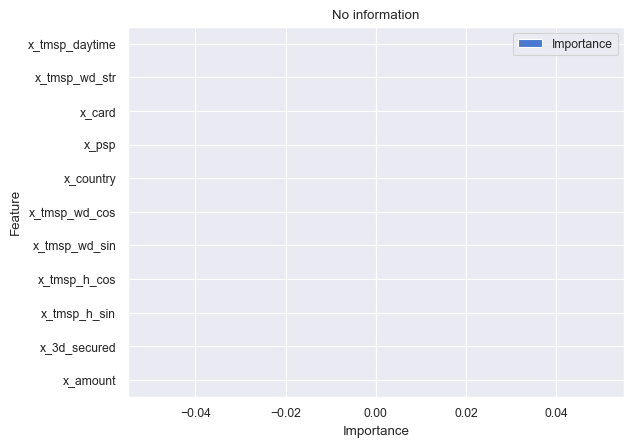

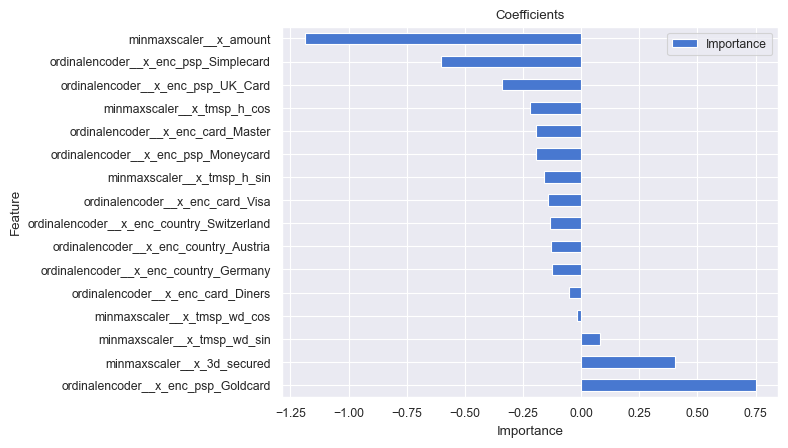

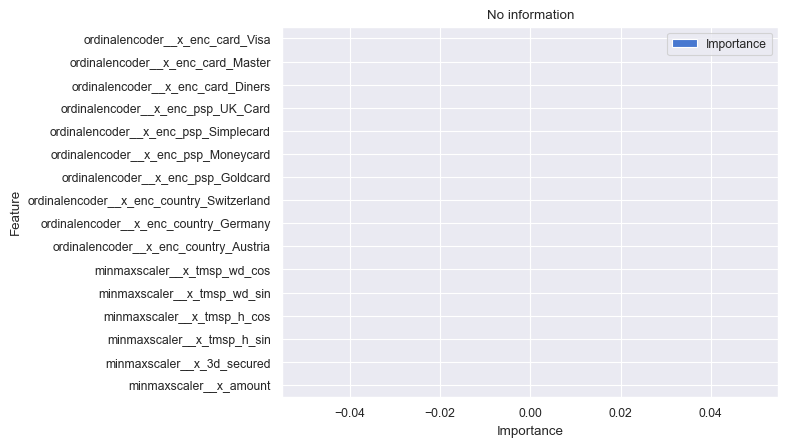

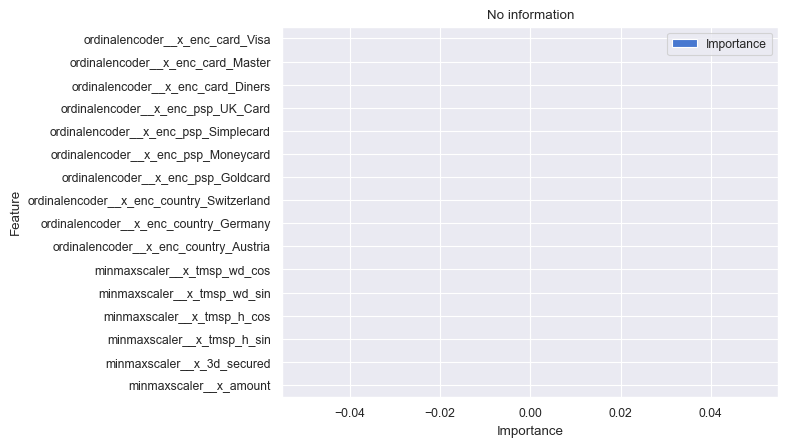

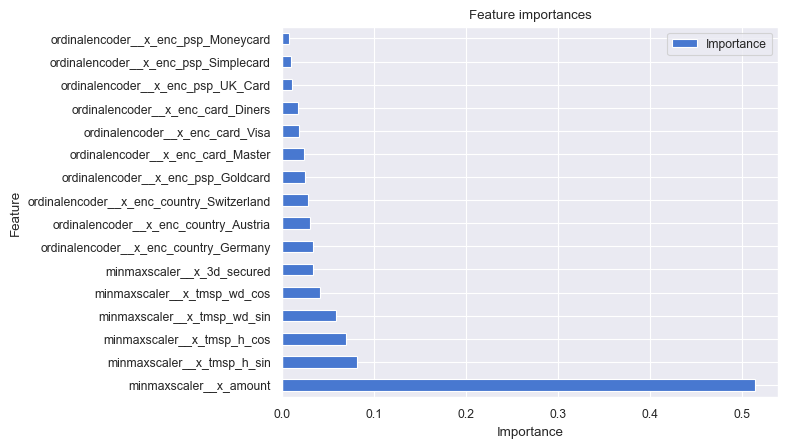

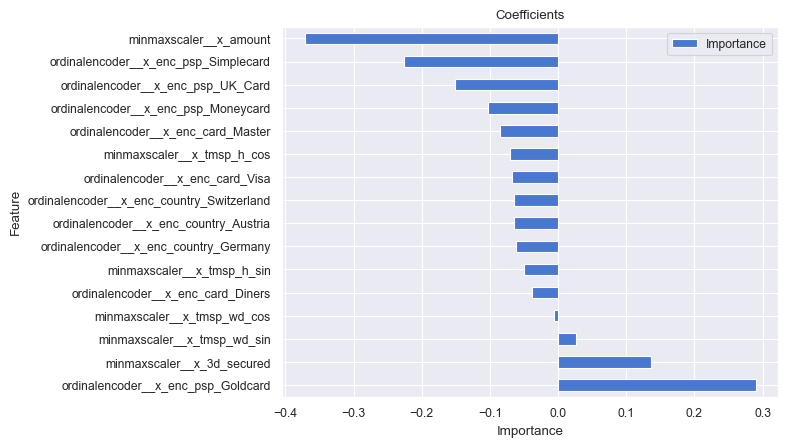

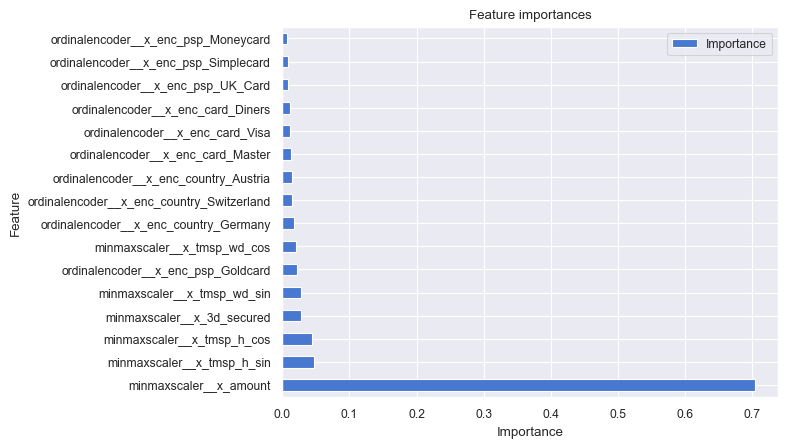

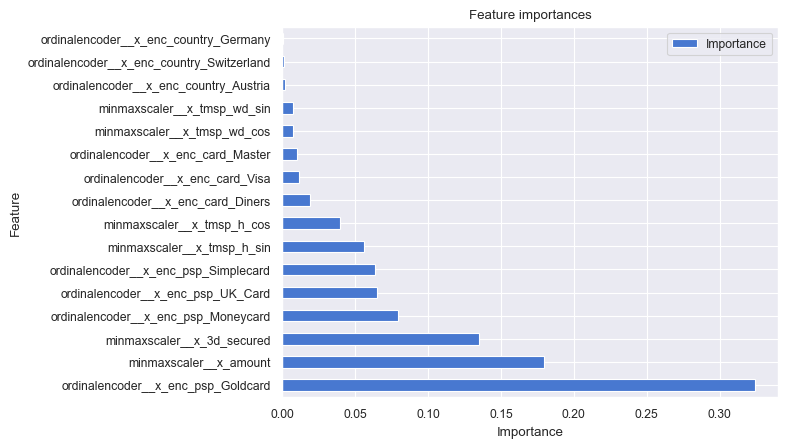

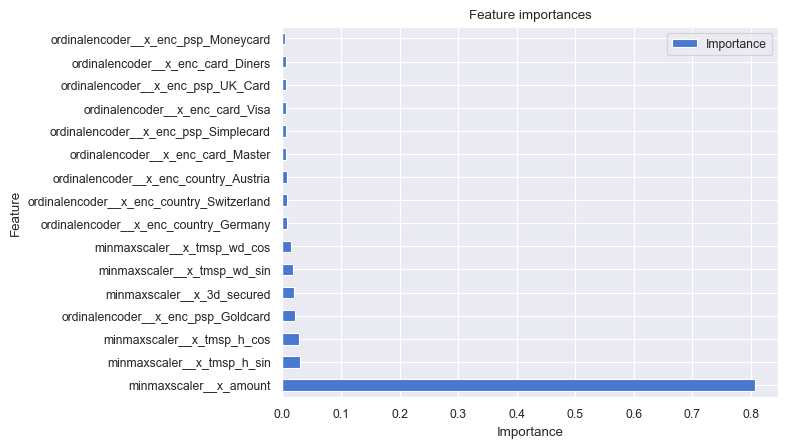

In [17]:
first_exp = "PSP_1st_comparison_NEW"
first_info = "Training for first comparison of models WITHOUT hyperparameter tuning"
for n, c, fm in first_step_zip:
    print(f"Training and logging of model {n} as classifier {c} with feature mode {fm}")
    if fm == "raw":
        x_train = x_train_raw
        x_test = x_test_raw
        feature_names = list(x_train_raw.columns)
    else:
        x_train = x_train_numerical
        x_test = x_test_numerical
        feature_names = list(coltransformer_4numerical.get_feature_names_out())
        
    # Create a new MLflow Experiment
    mlflow.set_experiment(first_exp)
    
    # Start an MLflow run
    run_name = dt_today + "_" + n
    with mlflow.start_run(run_name=run_name) as run:
        training_info = n + " - " + first_info
        # Training and prediction
        model = c
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        track_model(training_info, model, y_test, y_pred, feature_names)

        run_id = run.info.run_id
    
    print(f"For {n}: Run logged in MLflow with {run_id}.")
    print("---------------------- \n")